# Inventory Prediction - Model Training

In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Advanced ML libraries
import xgboost as xgb
import lightgbm as lgb

# Model persistence
import joblib
import pickle

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Preprocessed Data

In [19]:
# Load processed data
data_path = '/content/processed_kaggle_sales_data.csv'
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])

print(f"Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
df.head()

Data loaded successfully!
Shape: (87556, 56)
Date range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00


,date,store,item,sales,year_month,year,month,day_of_week,day,week_of_year,...,sales_rolling_min_90,sales_rolling_max_90,store_avg_sales,store_std_sales,store_median_sales,item_avg_sales,item_std_sales,item_median_sales,store_item_avg_sales,store_item_std_sales
0,2013-01-01,1,1,13,2013-01,2013,1,1,1,1,...,13.0,13.0,47.268379,24.006252,44.0,21.981599,8.468922,21.0,19.971522,6.741022
1,2013-01-02,1,1,11,2013-01,2013,1,2,2,1,...,11.0,13.0,47.268379,24.006252,44.0,21.981599,8.468922,21.0,19.971522,6.741022
2,2013-01-03,1,1,14,2013-01,2013,1,3,3,1,...,11.0,14.0,47.268379,24.006252,44.0,21.981599,8.468922,21.0,19.971522,6.741022
3,2013-01-04,1,1,13,2013-01,2013,1,4,4,1,...,11.0,14.0,47.268379,24.006252,44.0,21.981599,8.468922,21.0,19.971522,6.741022
4,2013-01-05,1,1,10,2013-01,2013,1,5,5,1,...,10.0,14.0,47.268379,24.006252,44.0,21.981599,8.468922,21.0,19.971522,6.741022


## 2. Feature Selection & Preparation

In [20]:
# Define features to use for modeling
# Exclude non-predictive columns
exclude_cols = ['date', 'product', 'store', 'sales', 'year_month', 'inventory_level']

# Select feature columns
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Total features selected: {len(feature_cols)}")
print("\nFeature categories:")
print(f"  Time features: {[c for c in feature_cols if any(t in c for t in ['year', 'month', 'day', 'week', 'quarter', 'weekend'])]}")
print(f"\n  Lag features: {[c for c in feature_cols if 'lag' in c]}")
print(f"\n  Rolling features: {[c for c in feature_cols if 'rolling' in c]}")
print(f"\n  Other features: {[c for c in feature_cols if not any(t in c for t in ['lag', 'rolling', 'year', 'month', 'day', 'week', 'quarter', 'weekend'])]}")

Total features selected: 52

Feature categories:
  Time features: ['year', 'month', 'day_of_week', 'day', 'week_of_year', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end', 'day_of_year', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin', 'day_of_year_cos']

  Lag features: ['sales_lag_1', 'sales_lag_3', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 'sales_lag_60', 'sales_lag_90']

  Rolling features: ['sales_rolling_mean_7', 'sales_rolling_std_7', 'sales_rolling_min_7', 'sales_rolling_max_7', 'sales_rolling_mean_14', 'sales_rolling_std_14', 'sales_rolling_min_14', 'sales_rolling_max_14', 'sales_rolling_mean_30', 'sales_rolling_std_30', 'sales_rolling_min_30', 'sales_rolling_max_30', 'sales_rolling_mean_60', 'sales_rolling_std_60', 'sales_rolling_min_60', 'sales_rolling_max_60', 'sales_rolling_mean_90', 'sales_rolling_std_90', 'sales_rolling_min_90', 'sales_rolling_max_90']

  Other features: ['item', 'store_avg_sales', 'store_std_sales', 'store

In [21]:
# Prepare X (features) and y (target)
X = df[feature_cols].copy()
y = df['sales'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nTarget statistics:")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std: {y.std():.2f}")
print(f"  Min: {y.min():.2f}")
print(f"  Max: {y.max():.2f}")

Feature matrix shape: (87556, 52)
Target vector shape: (87556,)

Target statistics:
  Mean: 47.45
  Std: 24.12
  Min: 1.00
  Max: 155.00


In [22]:
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"Converting {col} from object to numeric...")
        X[col] = pd.to_numeric(X[col], errors='coerce')

## 3. Train-Test Split (Time-Series Aware)

In [23]:
# Time-based split: Use last 20% of data for testing
split_date = df['date'].quantile(0.8)
print(f"Split date: {split_date}")

train_mask = df['date'] < split_date
test_mask = df['date'] >= split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\nTraining set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

Split date: 2016-12-30 00:00:00

Training set: 70,032 samples (80.0%)
Test set: 17,524 samples (20.0%)


In [15]:
# Check for non-numeric columns in X
print("=== DATA TYPES IN FEATURE MATRIX ===")
print(X.dtypes)

print("\n=== NON-NUMERIC COLUMNS ===")
non_numeric = X.select_dtypes(include=['object', 'string']).columns.tolist()
if non_numeric:
    print(f"Found {len(non_numeric)} non-numeric columns: {non_numeric}")
    print("\n=== SAMPLE VALUES FROM NON-NUMERIC COLUMNS ===")
    for col in non_numeric:
        print(f"\n{col}:")
        print(X[col].value_counts().head(10))
else:
    print("No non-numeric columns found!")

print("\n=== MISSING VALUES ===")
missing = X.isnull().sum()
if missing.any():
    print(missing[missing > 0])
else:
    print("No missing values!")

print("\n=== INFINITY VALUES ===")
inf_cols = []
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        if np.isinf(X[col]).any():
            inf_cols.append(col)
            print(f"{col}: {np.isinf(X[col]).sum()} infinity values")
if not inf_cols:
    print("No infinity values!")

=== DATA TYPES IN FEATURE MATRIX ===
item                       int64
year                       int64
month                      int64
day_of_week                int64
day                        int64
week_of_year               int64
quarter                    int64
is_weekend                 int64
is_month_start             int64
is_month_end               int64
day_of_year                int64
month_sin                float64
month_cos                float64
day_of_week_sin          float64
day_of_week_cos           object
day_of_year_sin          float64
day_of_year_cos          float64
sales_lag_1              float64
sales_lag_3              float64
sales_lag_7              float64
sales_lag_14             float64
sales_lag_30             float64
sales_lag_60             float64
sales_lag_90             float64
sales_rolling_mean_7     float64
sales_rolling_std_7      float64
sales_rolling_min_7      float64
sales_rolling_max_7      float64
sales_rolling_mean_14    float64
sales_

In [24]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print(f"Mean of scaled training features: {X_train_scaled.mean():.6f}")
print(f"Std of scaled training features: {X_train_scaled.std():.6f}")

Features scaled successfully!
Mean of scaled training features: -0.000000
Std of scaled training features: 0.970725


## 4. Model Training

### 4.1 Linear Regression

In [26]:
print("Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Metrics
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print(f"✓ Linear Regression trained!")
print(f"  Train RMSE: {train_rmse_lr:.2f} | Test RMSE: {test_rmse_lr:.2f}")
print(f"  Train MAE: {train_mae_lr:.2f} | Test MAE: {test_mae_lr:.2f}")
print(f"  Train R²: {train_r2_lr:.4f} | Test R²: {test_r2_lr:.4f}")

Training Linear Regression...
✓ Linear Regression trained!
  Train RMSE: 6.66 | Test RMSE: 7.29
  Train MAE: 5.16 | Test MAE: 5.62
  Train R²: 0.9182 | Test R²: 0.9234


### 4.2 Ridge Regression

In [28]:
print("Training Ridge Regression...")
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_ridge = ridge_model.predict(X_train_scaled)
y_test_pred_ridge = ridge_model.predict(X_test_scaled)

# Metrics
train_rmse_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

print(f"✓ Ridge Regression trained!")
print(f"  Train RMSE: {train_rmse_ridge:.2f} | Test RMSE: {test_rmse_ridge:.2f}")
print(f"  Train MAE: {train_mae_ridge:.2f} | Test MAE: {test_mae_ridge:.2f}")
print(f"  Train R²: {train_r2_ridge:.4f} | Test R²: {test_r2_ridge:.4f}")

Training Ridge Regression...
✓ Ridge Regression trained!
  Train RMSE: 6.66 | Test RMSE: 7.29
  Train MAE: 5.16 | Test MAE: 5.62
  Train R²: 0.9182 | Test R²: 0.9234


### 4.3 Random Forest

In [29]:
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Metrics
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print(f"✓ Random Forest trained!")
print(f"  Train RMSE: {train_rmse_rf:.2f} | Test RMSE: {test_rmse_rf:.2f}")
print(f"  Train MAE: {train_mae_rf:.2f} | Test MAE: {test_mae_rf:.2f}")
print(f"  Train R²: {train_r2_rf:.4f} | Test R²: {test_r2_rf:.4f}")

Training Random Forest...
✓ Random Forest trained!
  Train RMSE: 3.50 | Test RMSE: 6.34
  Train MAE: 2.67 | Test MAE: 4.79
  Train R²: 0.9774 | Test R²: 0.9421


### 4.4 XGBoost

In [30]:
print("Training XGBoost...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train, verbose=False)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Metrics
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
train_mae_xgb = mean_absolute_error(y_train, y_train_pred_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
train_r2_xgb = r2_score(y_train, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test, y_test_pred_xgb)

print(f"✓ XGBoost trained!")
print(f"  Train RMSE: {train_rmse_xgb:.2f} | Test RMSE: {test_rmse_xgb:.2f}")
print(f"  Train MAE: {train_mae_xgb:.2f} | Test MAE: {test_mae_xgb:.2f}")
print(f"  Train R²: {train_r2_xgb:.4f} | Test R²: {test_r2_xgb:.4f}")

Training XGBoost...
✓ XGBoost trained!
  Train RMSE: 5.36 | Test RMSE: 6.22
  Train MAE: 4.16 | Test MAE: 4.75
  Train R²: 0.9470 | Test R²: 0.9442


### 4.5 LightGBM

In [31]:
print("Training LightGBM...")
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

# Predictions
y_train_pred_lgb = lgb_model.predict(X_train)
y_test_pred_lgb = lgb_model.predict(X_test)

# Metrics
train_rmse_lgb = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))
test_rmse_lgb = np.sqrt(mean_squared_error(y_test, y_test_pred_lgb))
train_mae_lgb = mean_absolute_error(y_train, y_train_pred_lgb)
test_mae_lgb = mean_absolute_error(y_test, y_test_pred_lgb)
train_r2_lgb = r2_score(y_train, y_train_pred_lgb)
test_r2_lgb = r2_score(y_test, y_test_pred_lgb)

print(f"✓ LightGBM trained!")
print(f"  Train RMSE: {train_rmse_lgb:.2f} | Test RMSE: {test_rmse_lgb:.2f}")
print(f"  Train MAE: {train_mae_lgb:.2f} | Test MAE: {test_mae_lgb:.2f}")
print(f"  Train R²: {train_r2_lgb:.4f} | Test R²: {test_r2_lgb:.4f}")

Training LightGBM...
✓ LightGBM trained!
  Train RMSE: 5.58 | Test RMSE: 6.29
  Train MAE: 4.33 | Test MAE: 4.83
  Train R²: 0.9426 | Test R²: 0.9430


## 5. Model Comparison

In [32]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Train_RMSE': [train_rmse_lr, train_rmse_ridge, train_rmse_rf, train_rmse_xgb, train_rmse_lgb],
    'Test_RMSE': [test_rmse_lr, test_rmse_ridge, test_rmse_rf, test_rmse_xgb, test_rmse_lgb],
    'Train_MAE': [train_mae_lr, train_mae_ridge, train_mae_rf, train_mae_xgb, train_mae_lgb],
    'Test_MAE': [test_mae_lr, test_mae_ridge, test_mae_rf, test_mae_xgb, test_mae_lgb],
    'Train_R2': [train_r2_lr, train_r2_ridge, train_r2_rf, train_r2_xgb, train_r2_lgb],
    'Test_R2': [test_r2_lr, test_r2_ridge, test_r2_rf, test_r2_xgb, test_r2_lgb]
})

# Calculate overfitting indicator
results['RMSE_Diff'] = results['Train_RMSE'] - results['Test_RMSE']
results['R2_Diff'] = results['Train_R2'] - results['Test_R2']

# Sort by Test RMSE
results = results.sort_values('Test_RMSE')

print("\n" + "=" * 100)
print("MODEL COMPARISON RESULTS")
print("=" * 100)
print(results.to_string(index=False))
print("=" * 100)

# Identify best model
best_model_name = results.iloc[0]['Model']
print(f"\n Best Model: {best_model_name}")
print(f"   Test RMSE: {results.iloc[0]['Test_RMSE']:.2f}")
print(f"   Test MAE: {results.iloc[0]['Test_MAE']:.2f}")
print(f"   Test R²: {results.iloc[0]['Test_R2']:.4f}")


MODEL COMPARISON RESULTS
            Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  RMSE_Diff   R2_Diff
          XGBoost    5.358853   6.222112   4.158295  4.754401  0.947047 0.944247  -0.863259  0.002800
         LightGBM    5.578064   6.292043   4.328136  4.831891  0.942626 0.942986  -0.713980 -0.000361
    Random Forest    3.501791   6.342929   2.665498  4.788293  0.977388 0.942060  -2.841138  0.035328
            Ridge    6.659963   7.294447   5.159432  5.616897  0.918211 0.923373  -0.634484 -0.005162
Linear Regression    6.659943   7.294778   5.159259  5.617459  0.918212 0.923366  -0.634836 -0.005155

 Best Model: XGBoost
   Test RMSE: 6.22
   Test MAE: 4.75
   Test R²: 0.9442


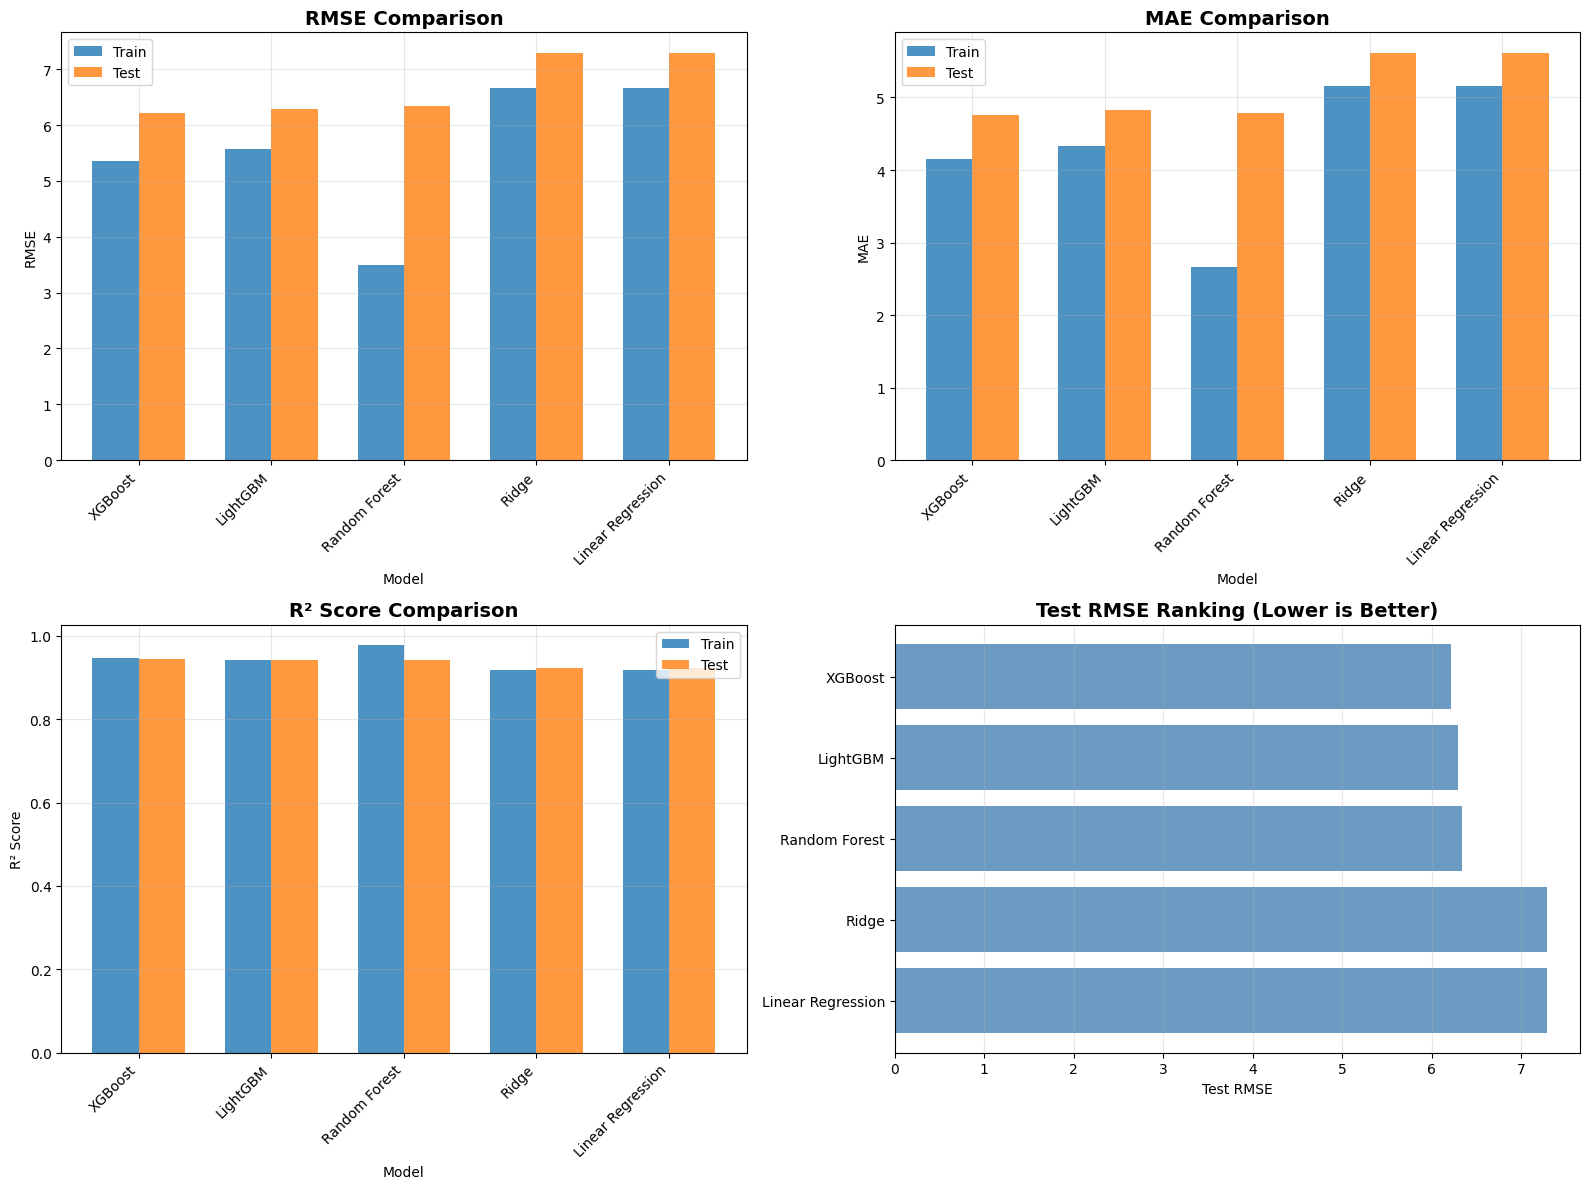

In [33]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE comparison
x = np.arange(len(results))
width = 0.35
axes[0, 0].bar(x - width/2, results['Train_RMSE'], width, label='Train', alpha=0.8)
axes[0, 0].bar(x + width/2, results['Test_RMSE'], width, label='Test', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(results['Model'], rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE comparison
axes[0, 1].bar(x - width/2, results['Train_MAE'], width, label='Train', alpha=0.8)
axes[0, 1].bar(x + width/2, results['Test_MAE'], width, label='Test', alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(results['Model'], rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# R² comparison
axes[1, 0].bar(x - width/2, results['Train_R2'], width, label='Train', alpha=0.8)
axes[1, 0].bar(x + width/2, results['Test_R2'], width, label='Test', alpha=0.8)
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(results['Model'], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Test RMSE ranking
axes[1, 1].barh(results['Model'], results['Test_RMSE'], color='steelblue', alpha=0.8)
axes[1, 1].set_xlabel('Test RMSE')
axes[1, 1].set_title('Test RMSE Ranking (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

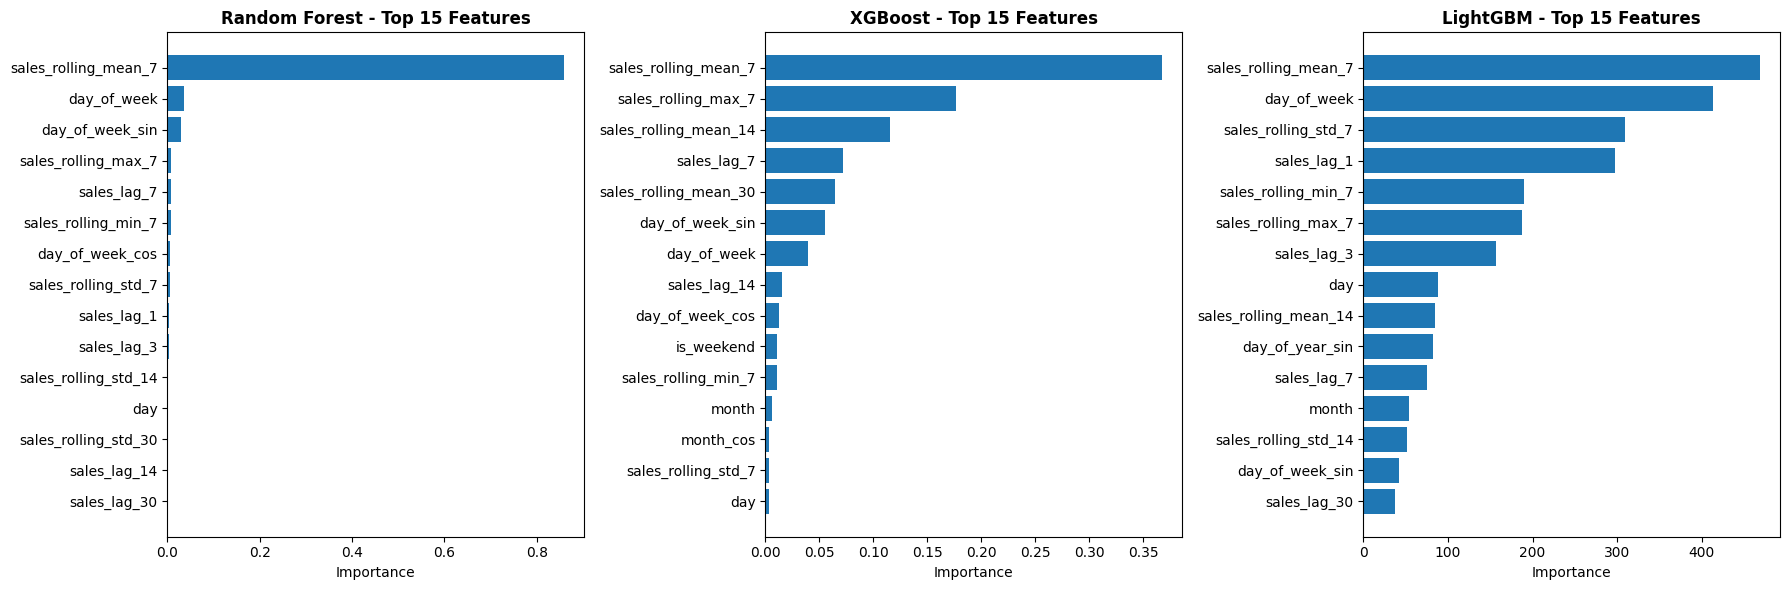

In [34]:
# Feature importance from tree-based models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Random Forest
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[0].barh(rf_importance['feature'], rf_importance['importance'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 15 Features', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# XGBoost
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1].barh(xgb_importance['feature'], xgb_importance['importance'])
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost - Top 15 Features', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

# LightGBM
lgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[2].barh(lgb_importance['feature'], lgb_importance['importance'])
axes[2].set_xlabel('Importance')
axes[2].set_title('LightGBM - Top 15 Features', fontsize=12, fontweight='bold')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Prediction Visualization

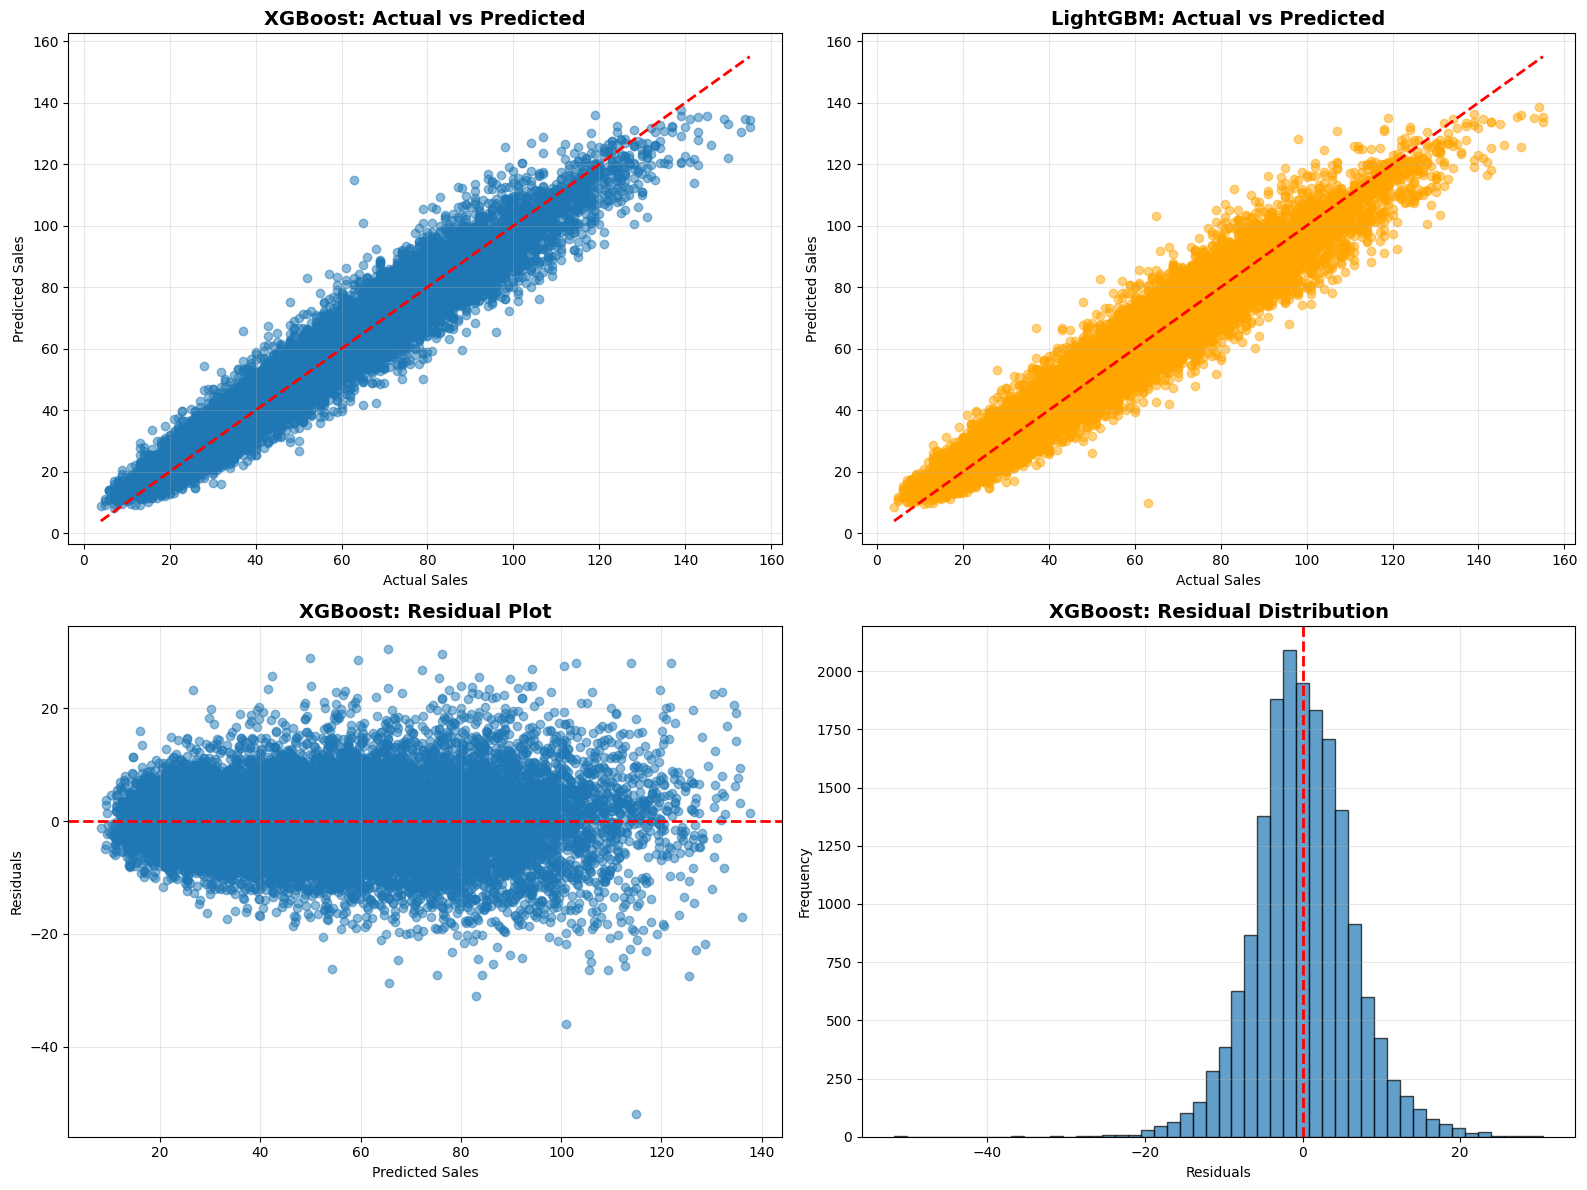

In [35]:
# Visualize predictions vs actual for best model (assuming XGBoost)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# XGBoost - Scatter plot
axes[0, 0].scatter(y_test, y_test_pred_xgb, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Sales')
axes[0, 0].set_ylabel('Predicted Sales')
axes[0, 0].set_title('XGBoost: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# LightGBM - Scatter plot
axes[0, 1].scatter(y_test, y_test_pred_lgb, alpha=0.5, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Sales')
axes[0, 1].set_ylabel('Predicted Sales')
axes[0, 1].set_title('LightGBM: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Residuals - XGBoost
residuals_xgb = y_test - y_test_pred_xgb
axes[1, 0].scatter(y_test_pred_xgb, residuals_xgb, alpha=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Sales')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('XGBoost: Residual Plot', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Residuals distribution
axes[1, 1].hist(residuals_xgb, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('XGBoost: Residual Distribution', fontsize=14, fontweight='bold')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Save Models

In [37]:
# Save all trained models
models = {
    'linear_regression': lr_model,
    'ridge': ridge_model,
    'random_forest': rf_model,
    'xgboost': xgb_model,
    'lightgbm': lgb_model
}

for name, model in models.items():
    model_path = f'/content/{name}_model.pkl'
    joblib.dump(model, model_path)
    print(f"✓ Saved: {model_path}")

# Save scaler
scaler_path = '/content/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ Saved: {scaler_path}")

# Save feature names
feature_path = '/content/feature_names.pkl'
joblib.dump(feature_cols, feature_path)
print(f"✓ Saved: {feature_path}")

# Save results
results_path = '/content/model_comparison.csv'
results.to_csv(results_path, index=False)
print(f"✓ Saved: {results_path}")

print("\nAll models saved successfully!")

✓ Saved: /content/linear_regression_model.pkl
✓ Saved: /content/ridge_model.pkl
✓ Saved: /content/random_forest_model.pkl
✓ Saved: /content/xgboost_model.pkl
✓ Saved: /content/lightgbm_model.pkl
✓ Saved: /content/scaler.pkl
✓ Saved: /content/feature_names.pkl
✓ Saved: /content/model_comparison.csv

All models saved successfully!


## Summary

In this notebook, we:
1. Loaded preprocessed data
2. Split data with time-series awareness
3. Trained 6 different ML models:
   - Linear Regression
   - Ridge Regression
   - Random Forest
   - XGBoost
   - LightGBM
   - Neural Network (MLP)
4. Compared model performance
5. Analyzed feature importance
6. Saved all models for future use